# SMS Spam Detection

Spam filtering using machine learning has become common among email providers. However, spam filtering of SMS text messages has not been widely implemented. A big reason for SMS to be lagging behind email in terms of spam filtering is the lack of a large, quality SMS text dataset. This dataset from UCI combines multiple different datasets together to provide an industry-leading SMS spam vs ham dataset.



The data preprocessing steps that we intend to implement are:

- Removing punctuation
- Lowercase all words
- Stemming/lemmatization
- Removing stopwords (tentative - shown to potentially reduce performance of spam detection models)
- Adding N-gram features
- Bag of words
- TF-IDF



The algorithms that we intend to explore are:

- Baseline (Trivial Rejector)
- Naive Bayes
- Support Vector Machines
- CNN
- RNN

## Key Performance Indicators:

In general, we want to maximize the percentage of spam messages that we are able to identify while also minimizing the number of legitimate messages that get flagged as spam. 

For this project, we will assume that the maximum amount of ham messages being labeled as spam that we can tolerate is **1 in 1 million** ham messages. This equates to a maximum false positive rate of **0.000001**. 

However, since we only have 5572 samples in the entire dataset, even a single false positive will cause our model to fail this test. Even a model that does only mislabel ham messages as spam once in a million messages will have a chance of creating a false positive in any given 5572 samples. As a result, we will accept a model if it has a false positive rate of 1/5572=**0.0001795**. This means that we can tolerate a single false positive when the model is evaluated against the entire dataset (such as in cross-validation). 

In the literature (see README), the top performing model caught approximately 83% of the spam messages (although the false positive rate was much higher than our threshold). Given our strict requirement on a low false positive rate, we will accept any model that has a true positive rate of >83% while also meeting staying below our false positive threshold.

## Install and import libraries

In [1600]:
!pip install gensim

You should consider upgrading via the '/home/ec2-user/anaconda3/envs/python3/bin/python -m pip install --upgrade pip' command.


In [1753]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
import seaborn as sns
import nltk
from nltk.corpus import stopwords
import string
import re
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_validate
from sklearn.model_selection import StratifiedKFold
from sklearn.pipeline import Pipeline
from sklearn import metrics
from sklearn.metrics import fbeta_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import make_scorer
from sklearn.naive_bayes import MultinomialNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from gensim.models import Word2Vec

## Define constants

In [1602]:
DATA_LOC = 'data/SMSSpamCollection'
TEST_RATIO = 0.4
INSPECT_ROWS = 100 
RANDOM_STATE = 12 # random value, this happens to be my favorite number
F1_BETA = 0.35
CV_FOLDS = 5
MAX_FPR = 0.0001795
DOWNLOAD_GLOVE = False

## Read data

In [1603]:
df = pd.read_csv(DATA_LOC, delimiter = '\t', header = None, names = ['spam', 'message'])

## Exploratory Data Analysis

In [1604]:
df.head(10)

,spam,message
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."
5,spam,FreeMsg Hey there darling it's been 3 week's n...
6,ham,Even my brother is not like to speak with me. ...
7,ham,As per your request 'Melle Melle (Oru Minnamin...
8,spam,WINNER!! As a valued network customer you have...
9,spam,Had your mobile 11 months or more? U R entitle...


Right off the bat, I'm noticing that spam messages may have all capital words, such as "WINNER", that might be indicative of spam. My original plan was to lowercase all words but that may be detrimental to the results. On the other hand, not lowercasing the word will cause words like "Winner" and "winner" to be considered different tokens.

#### Total number of samples

In [1605]:
len(df)

5572

#### Check for missing values

In [1606]:
df.isna().sum()

spam       0
message    0
dtype: int64

As expected, there are no missing values. This is good.

#### Inspect class distribution

In [1607]:
df.spam.value_counts()

ham     4825
spam     747
Name: spam, dtype: int64

In [1608]:
# class breakdown in percentage form
df.spam.value_counts() / len(df) * 100

ham     86.593683
spam    13.406317
Name: spam, dtype: float64

This class breakdown matches the dataset description. There is an obvious heavy bias towards ham (non-spam) messages. 86.6% of messages are ham and only 13.4% are spam. This is somewhat realistic, since the majority of messages are ham.

#### Visually inspect ham messages

In [1609]:
for index, row in df[df['spam'] == 'ham'].sample(INSPECT_ROWS, random_state = RANDOM_STATE).iterrows():
    print(row['message'])

I am not sure about night menu. . . I know only about noon menu
If you ask her or she say any please message.
K..k.:)congratulation ..
I have a sore throat. It's scratches when I talk
Im cool ta luv but v.tired 2 cause i have been doin loads of planning all wk, we have got our social services inspection at the nursery! Take care & spk sn x.
Uh, heads up we don't have THAT much left
Pls send me your address sir.
Dude u knw also telugu..thts gud..k, gud nyt..
Got it. Seventeen pounds for seven hundred ml – hope ok.
I didnt get ur full msg..sometext is missing, send it again
Haven't seen my facebook, huh? Lol!
Only just got this message, not ignoring you. Yes, i was. Shopping that is
Also remember the beads don't come off. Ever.
He needs to stop going to bed and make with the fucking dealing
K, wen ur free come to my home and also tel vikky i hav sent mail to him also.. Better come evening il be free today aftr 6pm..:-)
SYMPTOMS when U are in love: "1.U like listening songs 2.U get stopp

These messages are primarily from the UK, so the English is not typical for me and there are a lot of different spellings. That being said, there are still some obvious mispellings, such as "womdarfull", "frndsship", etc. There is also a lot of slang/shorthand, such as "b'day", "gr8", "K", "Dis", "thx", etc. There are also abbreviations such as "LOL". There are also some messages in other languages. I'm also noticing some weird characters, such as "`&lt; #&gt;`" indicating that the less-than and great-than symbols were used. 

In addition, after futher inspection of ham messages, I'm rethinking the idea to preserve capitalization. There are several ham messages that contain heavy capitalization as well, which means that capitalization is not necessarily and indication of spam and adding those words as special tokens may add unnecessary features or noise to the dataset. It may be interesting, however, to explore the correlation between the position of those capital letters within the message to the spam/ham label.

There is also punctuation that tends to be more indicative of a ham message, such as a smiley face :) or :-). I think preserving these types of symbols and punctuation marks might be valuable for the model. 

#### Visually inspect ham messages

In [1610]:
for index, row in df[df['spam'] == 'spam'].sample(INSPECT_ROWS, random_state = RANDOM_STATE).iterrows():
    print(row['message'])

SMS SERVICES For your inclusive text credits pls gotto www.comuk.net login 3qxj9 unsubscribe with STOP no extra charge help 08702840625 comuk.220cm2 9AE
Congrats! 1 year special cinema pass for 2 is yours. call 09061209465 now! C Suprman V, Matrix3, StarWars3, etc all 4 FREE! bx420-ip4-5we. 150pm. Dont miss out! 
tddnewsletter@emc1.co.uk (More games from TheDailyDraw) Dear Helen, Dozens of Free Games - with great prizesWith..
FreeMsg Today's the day if you are ready! I'm horny & live in your town. I love sex fun & games! Netcollex Ltd 08700621170150p per msg reply Stop to end
YOUR CHANCE TO BE ON A REALITY FANTASY SHOW call now = 08707509020 Just 20p per min NTT Ltd, PO Box 1327 Croydon CR9 5WB 0870 is a national = rate call
FreeMsg Hey U, i just got 1 of these video/pic fones, reply WILD to this txt & ill send U my pics, hurry up Im so bored at work xxx (18 150p/rcvd STOP2stop)
Want 2 get laid tonight? Want real Dogging locations sent direct 2 ur mob? Join the UK's largest Dogging Net

Here, I'm noticing that spam messages contain way more phone numbers, email addresses, hyperlinks, addresses, and prices (such as £2,000). It may be important to preserve some of these characteristics, since they seem more indicative of spam messages. I am also seeing many instances of the word "FREE" in various forms, as well as words like "CLAIM", "URGENT", "unsubscribe", "EXCLUSIVE", "CALL", etc.

#### Analyzing capitalization between spam and ham messages

In [1611]:
def num_capitalized(message):
    num_cap = 0
    words = message.split(' ')
    for word in words:
        if word.isupper():
            num_cap = num_cap + 1
    return num_cap

In [1612]:
ham_capitals = df[df['spam'] == 'ham'].apply(lambda row: num_capitalized(row['message']), axis=1)
spam_capitals = df[df['spam'] == 'spam'].apply(lambda row: num_capitalized(row['message']), axis=1)

In [1613]:
print('Ham Capitals: ')
print('Mean: ', ham_capitals.mean())
print('Standard deviation: ', ham_capitals.std())

print('------------------------------------------')

print('Spam Capitals: ')
print('Mean: ', spam_capitals.mean())
print('Standard deviation: ', spam_capitals.std())

Ham Capitals: 
Mean:  0.8230051813471503
Standard deviation:  2.7469584576414547
------------------------------------------
Spam Capitals: 
Mean:  2.6238286479250337
Standard deviation:  2.761594094683261


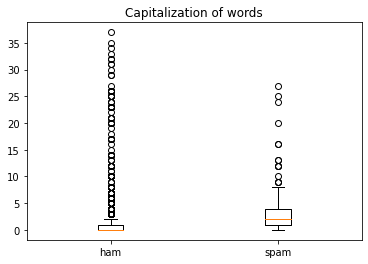

In [1614]:
plt.title('Capitalization of words')
plt.boxplot(x = [ham_capitals, spam_capitals], labels = ['ham', 'spam'])
plt.show()

From the above statistics and box plot, we can see that spam messages tend to have more capitalized words than ham messages. However, ham messages have far more outliers and can have over 35 capitalized words. Therefore, capitalization is not necessarily an indication of spam. Capitalization of certain words may still be indicative of spam, however, as we will explore below. We will use the word "free" and see how many times the word is capitalized in spam messages vs ham messages.

In [1615]:
# indicates the number of occurrences of 'FREE'
free_dict = {'spam': 0, 'ham': 0}

In [1616]:
for index, row in df.iterrows():
    message = row['message']
    label = row['spam']
    words = message.split(' ')
    for word in words:
        if 'free' in word.lower():                              # we split on whitespace so 'free' could be part of longer string, lowercasing to consistently find substring
            free_index = word.lower().index('free')             # getting position of 'free' substring for next step
            free = word[free_index : free_index + len('free')]  # getting slice of original string to check case
            if free.isupper():
                free_dict[label] = free_dict[label] + 1

In [1617]:
print('Number of messages containing the string \'FREE\':')
free_dict

Number of messages containing the string 'FREE':


{'spam': 134, 'ham': 1}

For our example of the word 'free', this corpus has 135 instances of the word in all caps. 134/135 (~99.3%) are from spam messages. While we do not want to have to hard code these types of rules, they may provide useful features in our dataset. As a result, I am leaning towards maintaining capitalization in the dataset by creating seperate tokens for capitalized words (instead of lowercasing everything first). 

It is worth noting that there was a ham message with a capitalized 'free'. Our goal is to prevent any ham messages from being flagged as spam (false positive). If our model uses the token for capital 'FREE' as a strong indicator of , it may misclassify that message as spam. 

#### Analyzing punctuation between spam and ham messages

We will be looking for the following punctuation marks:

In [1618]:
string.punctuation

'!"#$%&\'()*+,-./:;<=>?@[\\]^_`{|}~'

In [1619]:
punct_dict = {'spam': 0, 'ham': 0}

In [1620]:
for index, row in df.iterrows():
    message = row['message']
    label = row['spam']
    for char in message:
        if char in string.punctuation:
            punct_dict[label] = punct_dict[label] + 1

In [1621]:
print('Total number of punctuation marks for each class:')
punct_dict

Total number of punctuation marks for each class:


{'spam': 4267, 'ham': 19010}

Ham messages have more instances of punctuation but there's also way more ham messages than spam messages. Let's normalize these values by dividing by the total number of messages in each category in order to get the rate of punctuation per message.

In [1622]:
for key, value in punct_dict.items():
    punct_dict[key] = value / len(df[df['spam'] == key])

In [1623]:
print('Average number of punctuation marks per message:')
punct_dict

Average number of punctuation marks per message:


{'spam': 5.712182061579652, 'ham': 3.9398963730569947}

Now we can see that spam messages actually tend to have a higher number of punctuation marks than ham messages (spam messages had on average 5.7 punctuation marks per message, as opposed to 3.9 punctuation marks per message for ham messages). This is most likely due to the abundance of phone numbers, email addresses, and URL's in the spam messages. However, the presence of punctuation is not a great indicator of whether or not a message is spam because ham messages can also have lots of punctuation. We will now look into more advanced structures, such as email addresses and URL's. 

#### Analyze email address presence in messages

We will define an email address to be some combination of characters, then an '@' symbol, and then a domain name, which must start with a letter (to avoid messages like: "something@£1.50/month") and include a single period before the top level domain (like ".com" or ".com.uk"). This will convert into the following regex:

```
\S+@[a-zA-Z]\S+\.{1}\S+
```

In [1624]:
email_dict = {'spam': 0, 'ham': 0}

In [1625]:
email_regex = '\S+@[a-zA-Z]\S+\.{1}\S+'

In [1626]:
for index, row in df.iterrows():
    message = row['message']
    label = row['spam']
    emails = re.findall(email_regex, message)
    if not len(emails) == 0:
        print(emails)
        email_dict[label] = email_dict[label] + 1

['yijue@hotmail.com']
['info@ringtoneking.co.uk']
['tddnewsletter@emc1.co.uk']
['info@txt82228.co.uk']
['Dorothy@kiefer.com']
['msg+ticket@kiosk.Valid']
['customersqueries@netvision.uk.com']


In [1627]:
print('Number of messages containing an email address:')
email_dict

Number of messages containing an email address:


{'spam': 6, 'ham': 1}

We can see here that there were actually very few email addresses in the corpus but the majority of them belonged to spam messages. While the presence of an email address does indicate that the message may be spam, there are too few instances of email addresses to make this a feature in the dataset.  

#### Analyze URL presence in messages

We will define a URL as a string that may or may not begin with https:// or http://, may or may not contain www., then some domain name. The domain name must contain one of the following: 'net', 'com', 'edu', 'co', 'gov', 'xyz', 'info', 'top'. We will define the syntax of a URL with the following regex:

```
(?:http:\/\/|https:\/\/)?(?:www\.)?\S+\.{1}(?:net|com|edu|co|gov|xyz|info|top){1}\.?\S+
```

In [1628]:
url_dict = {'spam': 0, 'ham': 0}

In [1629]:
url_regex = '(?:http:\/\/|https:\/\/)?(?:www\.)?\S+\.{1}(?:net|com|edu|co|gov|xyz|info|top){1}\.?\S+'

In [1630]:
for index, row in df.iterrows():
    message = row['message']
    label = row['spam']
    urls = re.findall(url_regex, message)
    if not len(urls) == 0:
        print(urls)
        url_dict[label] = url_dict[label] + 1

['xxxmobilemovieclub.com?n=QJKGIGHJJGCBL']
['yijue@hotmail.com']
['www.areyouunique.co.uk']
['www.Ldew.com1win150ppmx3age16']
['club4mobiles.com']
['info:www.100percent-real.com']
['sextextuk.com']
['www.Ldew.com1win150ppmx3age16']
['www.regalportfolio.co.uk.']
['fullonsms.com']
['www.txttowin.co.uk']
['www.07781482378.com']
['http://www.bubbletext.com']
['www.Applausestore.com']
['www.txt-2-shop.com']
['gaytextbuddy.com.']
['http://www.e-tlp.co.uk/expressoffer']
['wikipedia.com']
['www.cnupdates.com/newsletter.']
['www.getzed.co.uk']
['www.Ldew.com1win150ppmx3age16']
['www.comuk.net']
['http://www.e-tlp.co.uk/expressoffer']
['magicalsongs.blogspot.com']
['www.getzed.co.uk']
['process.networking']
['http://www.urawinner.com']
['www.txt43.com']
['1stchoice.co.uk']
['fullonsms.com']
['lucozade.co.uk/wrc']
['PocketBabe.co.uk']
['www.Ldew.com.subs16+1win150ppmx3']
['www.phb1.com']
['www.textcomp.com']
['jamster.co.uk!']
['www.ringtones.co.uk,']
['PocketBabe.co.uk']
['icicibank.com']
['icic

In [1631]:
print('Number of messages containing a URL:')
url_dict

Number of messages containing a URL:


{'spam': 109, 'ham': 17}

There does appear to be a strong correlation between URL presence and spam, especially since there are far more ham messages than spam. However, there are only a total of 126 messages with a URL. We do not want to add a feature that really only applies to a small fraction of the total dataset. 

#### Analyze stop words in messages

A stop word is a word like "the", "an", "him", etc that do not add a lot of meaning to the text. We will look at home frequently stop words are used in spam vs ham messages to evaluate if removing those words will lose any valuable information.

In [1632]:
stop_dict = {'spam': 0, 'ham': 0}

In [1633]:
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to
[nltk_data]     /home/ec2-user/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [1634]:
stop_words = set(stopwords.words('english'))

In [1635]:
stop_words

{'a',
 'about',
 'above',
 'after',
 'again',
 'against',
 'ain',
 'all',
 'am',
 'an',
 'and',
 'any',
 'are',
 'aren',
 "aren't",
 'as',
 'at',
 'be',
 'because',
 'been',
 'before',
 'being',
 'below',
 'between',
 'both',
 'but',
 'by',
 'can',
 'couldn',
 "couldn't",
 'd',
 'did',
 'didn',
 "didn't",
 'do',
 'does',
 'doesn',
 "doesn't",
 'doing',
 'don',
 "don't",
 'down',
 'during',
 'each',
 'few',
 'for',
 'from',
 'further',
 'had',
 'hadn',
 "hadn't",
 'has',
 'hasn',
 "hasn't",
 'have',
 'haven',
 "haven't",
 'having',
 'he',
 'her',
 'here',
 'hers',
 'herself',
 'him',
 'himself',
 'his',
 'how',
 'i',
 'if',
 'in',
 'into',
 'is',
 'isn',
 "isn't",
 'it',
 "it's",
 'its',
 'itself',
 'just',
 'll',
 'm',
 'ma',
 'me',
 'mightn',
 "mightn't",
 'more',
 'most',
 'mustn',
 "mustn't",
 'my',
 'myself',
 'needn',
 "needn't",
 'no',
 'nor',
 'not',
 'now',
 'o',
 'of',
 'off',
 'on',
 'once',
 'only',
 'or',
 'other',
 'our',
 'ours',
 'ourselves',
 'out',
 'over',
 'own',
 'r

In [1636]:
for index, row in df.iterrows():
    message = row['message']
    label = row['spam']
    words = message.split(' ')
    for word in words:
        word = word.lower()        # stopwords lists are generally lowercase
        if word in stop_words:
            stop_dict[label] = stop_dict[label] + 1

In [1637]:
for key, value in stop_dict.items():
    stop_dict[key] = value / len(df[df['spam'] == key])

In [1638]:
print('Number of stop words used per message:')
stop_dict

Number of stop words used per message:


{'spam': 6.420348058902276, 'ham': 5.529326424870466}

While spam messages tend to use a slightly higher number of stop words, these values are close enough that removing stop words from all the messages should not lose any valuable information. It will reduce the number of features in our dataset.

#### Analyze length of messages

In [1639]:
ham_msgs = df[df['spam'] == 'ham']
spam_msgs = df[df['spam'] == 'spam']

# we will split the message on white spaces to get a list of words and then take the length of that list to get the number of words in the message
ham_word_lengths = ham_msgs.apply(lambda row: len(row['message'].split(' ')), axis=1)
spam_word_lengths = spam_msgs.apply(lambda row: len(row['message'].split(' ')), axis=1)

# we get length of raw message string to get number of characters in message
ham_char_lengths = ham_msgs.apply(lambda row: len(row['message']), axis=1)
spam_char_lengths = spam_msgs.apply(lambda row: len(row['message']), axis=1)

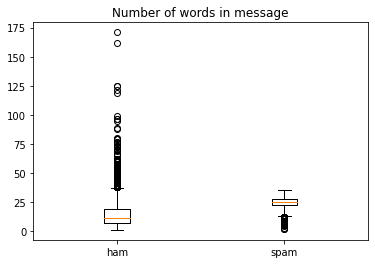

In [1640]:
plt.title('Number of words in message')
plt.boxplot(x = [ham_word_lengths, spam_word_lengths], labels = ['ham', 'spam'])
plt.show()

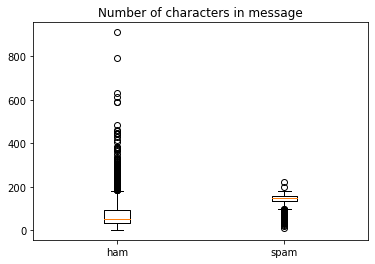

In [1641]:
plt.title('Number of characters in message')
plt.boxplot(x = [ham_char_lengths, spam_char_lengths], labels = ['ham', 'spam'])
plt.show()

For both words and characters, spam messages tend to have more. However, there are a very large number of outliers for ham messages that have more characters/words. It appears that no spam message exceeds 30 words or 200 characters, whereas many ham messages due. However, it may be difficult to incorporate this information because there is a lot of overlap between the two classes in terms of message length. We could automatically say that if a message has more than 30 words or 200 characters, it is ham, which would be accurate for our corpus but may not generalize to all SMS messages.

## Data preprocessing

From the conclusions drawn from the above data exploration, we will tokenize the messages, removing punctuation, and remove capitalization (with the exception of words that are completely capitalized like "FREE" or "URGENT", but we don't want "Free" and "free" to be separate tokens). We will also be removing stop words and words with length of one. We also need to convert the target variable, 'spam' into a 0/1.

In [1642]:
# removes punctuation, removes stop words, and lowercases the word unless that word is completely capitalized
def pre_tokenize_processing(message):
    # remove punctuation
    translator = str.maketrans(string.punctuation, ' '*len(string.punctuation))
    message = message.translate(translator)
    
    # remove stopwords and words of length one
    words = message.split(' ')
    filtered_words = []
    for word in words:
        if not word in stop_words and len(word) > 1:
            filtered_words.append(word)
    
    # lowercase word unless word is completely capitalized
    
    new_words = []
    for word in filtered_words:
        if not word.isupper():     # only fails if word is completely capitalized
            word = word.lower()
        new_words.append(word)
    new_msg = ' '.join(word for word in new_words) # reconstruct message from list of new words
    return new_msg

In [1643]:
# preprocess message before tokenizing
df['message'] = df.apply(lambda row: pre_tokenize_processing(row['message']), axis=1)

In [1644]:
# map target variable into numeric values
spam_map = {'ham': 0, 'spam': 1}
df['spam'] = df['spam'].map(spam_map)

In [1645]:
df

,spam,message
0,0,go jurong point crazy available bugis great wo...
1,0,ok lar joking wif oni
2,1,free entry wkly comp win FA cup final tkts 21s...
3,0,dun say early hor already say
4,0,nah think goes usf lives around though
...,...,...
5567,1,this 2nd time tried contact £750 pound prize c...
5568,0,will going esplanade fr home
5569,0,pity mood so suggestions
5570,0,the guy bitching acted like interested buying ...


### Split data into train and test sets

In [1646]:
X = df['message']
y = df['spam']

In [1647]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state = RANDOM_STATE, test_size = TEST_RATIO)

In [1648]:
print('Number of rows in training dataset (these should match)')
print('X_train: ', X_train.shape[0])
print('y_train: ', y_train.shape[0])

Number of rows in training dataset (these should match)
X_train:  3343
y_train:  3343


In [1649]:
print('Number of rows in test dataset (these should match)')
print('X_test: ', X_test.shape[0])
print('y_test: ', y_test.shape[0])

Number of rows in test dataset (these should match)
X_test:  2229
y_test:  2229


### Tokenizing 

min_df specifies the minimum document frequency of a word to become a token. We chose 0.0005, which means that words need to appear in at least 3 of the messages in order to become a token. max_df specifies the maximum document frequency of a word to become a token. However, since we already removed stop words, this is unlikely to have effect. We will be only generating unigrams so we are specifying the ngram_range = (1,1).

In [1650]:
count_vect = CountVectorizer(lowercase=False, strip_accents='ascii', ngram_range=(1,1), max_df=0.9, min_df=0.0005)
X_train = count_vect.fit_transform(X_train)
X_test = count_vect.transform(X_test)       # we only call transform because we do not want to fit on the test data

In [1651]:
X_train.shape

(3343, 3088)

The test set should have the same number of features because it will use the vocabulary that was created using the training set. 

In [1652]:
X_test.shape

(2229, 3088)

### Converting to TF-IDF

In [1653]:
tfidf_trfmr = TfidfTransformer()
X_train = tfidf_trfmr.fit_transform(X_train)
X_test = tfidf_trfmr.transform(X_test)       # we only call transform because we do not want to fit on the test data

In [1654]:
X_train.shape

(3343, 3088)

Again, we should see the same number of columns here. The TF-IDF operation should not change the shape of the data.

In [1655]:
X_test.shape

(2229, 3088)

This data is stored in a scipy sparse array, which is more space efficient since most of the values are zeroes. If stored in a traditional dataframe, this new dataset would take ~62 MB to store. While this is fairly modest, we may run into RAM limitations with larger datasets.

## Setting up model evaluation

**Note on evaluation metric:**

With SMS Spam detection, even a single legitimate message being blocked is unacceptable. As a result, we need to make sure we have perfect (or near perfect) precision. Obviously, we want our recall to be as high as possible but we want to put more weight on precision. As a result, we will be using an Fbeta measure with a beta value of <1 to give more weight to precision. 

In [1656]:
def get_fpr(y_actual, y_hat):
    # convert to numpy arrays so they can be indexed (y_test is a Pandas Series)
    y_actual = np.asarray(y_actual)
    y_hat = np.asarray(y_hat)
    
    fp = 0
    tn = 0

    if not len(y_hat) == len(y_actual):
        raise
    
    for i in range(len(y_hat)): 
        if y_hat[i]==1 and y_actual[i]!=y_hat[i]:
           fp += 1
        if y_actual[i]==y_hat[i]==0:
           tn += 1
        
    fpr = fp/(fp+tn)
    return fpr

In [1657]:
def get_tpr(y_actual, y_hat):
    # convert to numpy arrays so they can be indexed (y_test is a Pandas Series)
    y_actual = np.asarray(y_actual)
    y_hat = np.asarray(y_hat)
    
    tp = 0
    fn = 0

    if not len(y_hat) == len(y_actual):
        raise
    
    for i in range(len(y_hat)): 
        if y_actual[i]==y_hat[i]==1:
           tp += 1
        if y_hat[i]==0 and y_actual[i]!=y_hat[i]:
           fn += 1

    tpr = tp/(tp+fn)
    return tpr

In [1658]:
def evaluate(predictions):
    if not len(predictions) == len(y_test):
        raise
    
    keys = list(spam_map.keys())
    
    # print classification report
    print(metrics.classification_report(y_test, predictions,
        target_names=keys, zero_division=1))

    # display confusion matrix
    cm = confusion_matrix(y_test, predictions)
    ax = plt.subplot()
    sns.heatmap(cm, annot=True, fmt='g', ax=ax);  #annot=True to annotate cells, ftm='g' to disable scientific notation
    # labels, title and ticks
    ax.set_xlabel('Predicted labels');ax.set_ylabel('True labels'); 
    ax.set_title('Confusion Matrix'); 
    ax.xaxis.set_ticklabels(keys); ax.yaxis.set_ticklabels(keys);
    plt.show()
    
    # print false positive and false negative rates
    fpr = get_fpr(y_test, predictions)
    tpr = get_tpr(y_test, predictions)
    print('Blocked ham (false positive rate): {}%'.format(fpr))
    print('Meets false positive threshold? ', ('yes' if fpr<MAX_FPR else 'no'))
    print('Spam caught (true positive rate): {}%'.format(tpr))
    
    # print F1Beta score
    score = fbeta_score(y_test, predictions, beta=F1_BETA)
    print('F1 Beta Score: ', score)

In [1659]:
# use F1 beta score as scoring metric for grid search and cross validation methods
fbeta_scorer = make_scorer(fbeta_score, beta=F1_BETA)

In [1660]:
fpr_scorer = make_scorer(get_fpr, greater_is_better=False)
tpr_scorer = make_scorer(get_tpr, greater_is_better=True)

## Creating a baseline model

#### Baseline 1: Trivial Rejector

The literature uses a Trivial Rejector as an initial baseline. This baseline model labels every message as ham. We will implement this to see how well it does on our data set. 

In [1661]:
def tr_predict(data):
    return np.zeros(data.shape[0])

In [1662]:
tr_predictions = tr_predict(X_test)

In [1663]:
np.mean(tr_predictions == y_test)

0.8600269179004038

              precision    recall  f1-score   support

         ham       0.86      1.00      0.92      1917
        spam       1.00      0.00      0.00       312

    accuracy                           0.86      2229
   macro avg       0.93      0.50      0.46      2229
weighted avg       0.88      0.86      0.80      2229



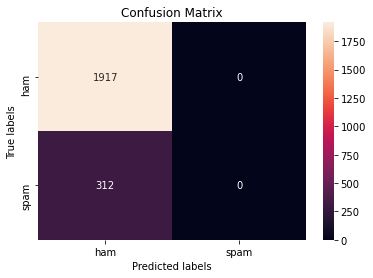

Blocked ham (false positive rate): 0.0%
Meets false positive threshold?  yes
Spam caught (true positive rate): 0.0%
F1 Beta Score:  0.0


In [1664]:
evaluate(tr_predictions)

Using our Trivial Rejector, we obtain an accuracy of 0.86. We obtain a false positive rate of 0, but this is only because we are labeling every message as ham. We are getting a true positive rate of 0.0, which means we are not finding any spam messages. 

#### Baseline 2: Multinomial Naive Bayes

Naive Bayes is a popular algorithm for text classification problems. The literature also suggests that this algorithm works reasonably well on this dataset. The default scikit-learn Multinomial Naive Bayes algorithm will serve as a solid baseline for our future experiments.

In [1665]:
nb_clf = MultinomialNB()
nb_clf.fit(X_train, y_train)

MultinomialNB()

              precision    recall  f1-score   support

         ham       0.97      1.00      0.98      1917
        spam       1.00      0.79      0.88       312

    accuracy                           0.97      2229
   macro avg       0.98      0.90      0.93      2229
weighted avg       0.97      0.97      0.97      2229



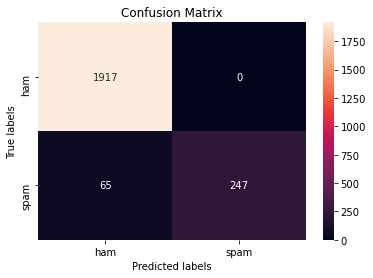

Blocked ham (false positive rate): 0.0%
Meets false positive threshold?  yes
Spam caught (true positive rate): 0.7916666666666666%
F1 Beta Score:  0.9720829535095716


In [1666]:
nb_predictions = nb_clf.predict(X_test)
evaluate(nb_predictions)

Using the default scikit-learn Multinomial Naive Bayes algorithm, we are actually able to achieve some pretty good results. We have a false positive rate of 0, which means we are not classifying any legitimate messages as spam. We are catching about 79% of the spam messages that come through. This will serve as a more realistic baseline model.

### Putting the above steps into a pipeline

In order to make the process more repeatable, we will create a Pipeline containing our tokenizer, our TF-IDF transformer, and our algorithm. We repeat the split so we get a new train and test set that has not been processed. We should get the exact same results:

In [1667]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state = RANDOM_STATE, test_size = TEST_RATIO)

              precision    recall  f1-score   support

         ham       0.97      1.00      0.98      1917
        spam       1.00      0.79      0.88       312

    accuracy                           0.97      2229
   macro avg       0.98      0.90      0.93      2229
weighted avg       0.97      0.97      0.97      2229



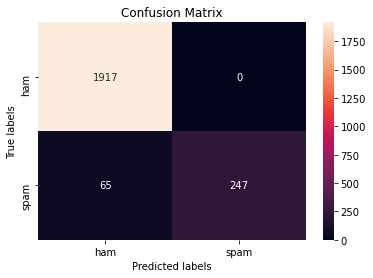

Blocked ham (false positive rate): 0.0%
Meets false positive threshold?  yes
Spam caught (true positive rate): 0.7916666666666666%
F1 Beta Score:  0.9720829535095716


In [1668]:
spam_pipeline = Pipeline([('vect', CountVectorizer(lowercase=False, strip_accents='ascii', ngram_range=(1,1), max_df=0.9, min_df=0.0005)),
                          ('tfidf', TfidfTransformer()),
                          ('nb', MultinomialNB()),])

spam_pipeline.fit(X_train, y_train)
preds = spam_pipeline.predict(X_test)
evaluate(preds)

As predicted, we get the same results. Pipelining our solution will help optimize hyperparameters as well as easily swap various components. 

## Naive Bayes

Our Naive Bayes classifier performed quite well using the default sklearn parameters. Let's see if we find a set of hyperparameters that can do even better. We will also include the possibility of bigrams, by allowing our CountVectorizer to include unigrams and bigrams. We will be leaving the rest of the hyperparameters as the same values as before, since they were specifically chosen based on our data preprocessing steps.

In [1669]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state = RANDOM_STATE, test_size = TEST_RATIO)

              precision    recall  f1-score   support

         ham       0.98      1.00      0.99      1917
        spam       1.00      0.86      0.92       312

    accuracy                           0.98      2229
   macro avg       0.99      0.93      0.96      2229
weighted avg       0.98      0.98      0.98      2229



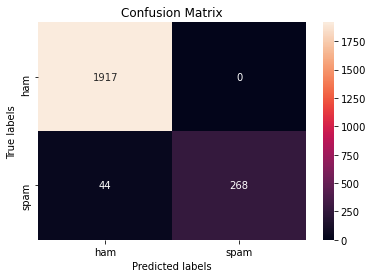

Blocked ham (false positive rate): 0.0%
Meets false positive threshold?  yes
Spam caught (true positive rate): 0.8589743589743589%
F1 Beta Score:  0.9823982757494613
{'nb__alpha': 0.25, 'vect__ngram_range': (1, 2)}


In [1670]:
spam_pipeline = Pipeline([('vect', CountVectorizer(lowercase=False, strip_accents='ascii', max_df=0.9, min_df=0.0005)),
                          ('tfidf', TfidfTransformer()),
                          ('nb', MultinomialNB()),])

# will try 12 different combinations
parameters = {
    'vect__ngram_range': [(1, 1), (1, 2)],
    'nb__alpha': [0.01, 0.1, 0.25, 0.5, 1, 2]
}

gs_nb = GridSearchCV(spam_pipeline, parameters, scoring=fbeta_scorer, cv=CV_FOLDS, n_jobs=-1)

gs_nb.fit(X_train, y_train)
preds = gs_nb.predict(X_test)
evaluate(preds)

print(gs_nb.best_params_)

Optimizing the hyperparameters allowed us to boost our F1 Beta score slightly (from 0.972 to 0.982). We also caught more spam (85.9% as opposed to 79.2%). More importantly, we still did not mark any ham as spam, so our model was a definite improvement over the default Naive Bayes.

This model appears to meet our KPI's for the project (on the hold-out set), staying below the maximum false positive threshold while also exceeding an 83% true positive rate. We will verify our results using cross-validation:

In [1671]:
# recreate pipeline with optimal hyperparameters
spam_pipeline = Pipeline([('vect', CountVectorizer(lowercase=False, strip_accents='ascii', max_df=0.9, min_df=0.0005)),
                          ('tfidf', TfidfTransformer()),
                          ('nb', MultinomialNB()),])

spam_pipeline.set_params(**gs_nb.best_params_)

Pipeline(steps=[('vect',
                 CountVectorizer(lowercase=False, max_df=0.9, min_df=0.0005,
                                 ngram_range=(1, 2), strip_accents='ascii')),
                ('tfidf', TfidfTransformer()),
                ('nb', MultinomialNB(alpha=0.25))])

In [1672]:
cv_metrics = {
    'fpr': fpr_scorer,
    'tpr': tpr_scorer,
    'fbeta': fbeta_scorer
}

cv_results = cross_validate(spam_pipeline, X, y, scoring=cv_metrics, cv=CV_FOLDS, n_jobs=-1)

In [1673]:
cv_results

{'fit_time': array([0.13958764, 0.13653326, 0.13196898, 0.12881804, 0.12939358]),
 'score_time': array([0.02890062, 0.03004622, 0.02767706, 0.02718592, 0.02758479]),
 'test_fpr': array([-0.00103627, -0.00207254, -0.        , -0.        , -0.00207254]),
 'test_tpr': array([0.92666667, 0.90666667, 0.85234899, 0.88590604, 0.89932886]),
 'test_fbeta': array([0.98517758, 0.97624301, 0.9814461 , 0.98614   , 0.97512196])}

In [1674]:
# Average F1 Beta score
np.mean(cv_results['test_fbeta'])

0.9808257299428771

In [1675]:
# Average False Positive Rate - note that metrics being minimized (great_is_better=False) are negated
np.mean(cv_results['test_fpr']) * -1

0.0010362694300518134

In [1676]:
# Average True Positive Rate
np.mean(cv_results['test_tpr'])

0.8941834451901567

From these results, we are seeing a false positive rate of 0.001, which means that approximately 1 in 1,000 legitimate messages would be flagged as spam. 

While this doesn't meet our threshold, these results are promising. In addition, we are catching 89.4% of spam, which is more than 10% better than our baseline naive bayes model and more than 6% better than the best baseline model in the literature. 

We didn't get any false positives with our original holdout set but we got some during cross validation. Let's see if we can print some of the **erors** by using a different holdout set (using RANDOM_STATE+1):

In [1677]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state = RANDOM_STATE+1, test_size = TEST_RATIO)

In [1678]:
# recreate pipeline with optimal hyperparameters
spam_pipeline = Pipeline([('vect', CountVectorizer(lowercase=False, strip_accents='ascii', max_df=0.9, min_df=0.0005)),
                          ('tfidf', TfidfTransformer()),
                          ('nb', MultinomialNB()),])

spam_pipeline.set_params(**gs_nb.best_params_)
spam_pipeline.fit(X_train, y_train)

Pipeline(steps=[('vect',
                 CountVectorizer(lowercase=False, max_df=0.9, min_df=0.0005,
                                 ngram_range=(1, 2), strip_accents='ascii')),
                ('tfidf', TfidfTransformer()),
                ('nb', MultinomialNB(alpha=0.25))])

In [1679]:
X_test_arr = np.asarray(X_test)
y_test_arr = np.asarray(y_test)

false_positives = []
false_negatives = []

for i in range(len(X_test_arr)):
    item = np.asarray([X_test_arr[i]])
    pred = spam_pipeline.predict(item)[0]
    actual = y_test_arr[i]
    
    # only look at incorrect predictions
    if not pred == actual:
        # false positives
        if pred == 1 and actual == 0:
            false_positives.append(X_test_arr[i])
        
        # false negatives
        elif pred == 0 and actual == 1:
            false_negatives.append(X_test_arr[i])

In [1680]:
print('Number of false positives: ', len(false_positives))
print('False positives: ')
print(false_positives)

Number of false positives:  3
False positives: 
['received understood acted upon', 'nokia phone lovly', 'deleted contact']


In [1681]:
print('Number of false negatives: ', len(false_negatives))
print('False negatives: ')
print(false_negatives)

Number of false negatives:  40
False negatives: 
['dear voucher holder claim 1st class airport lounge passes using your holiday voucher call 08704439680 when booking quote 1st class', 'reply name address YOU WILL RECEIVE BY POST weeks completely free accommodation various global locations www phb1 com ph 08700435505150p', '88066 FROM 88066 LOST 3POUND HELP', 'want cock my hubby away need real man satisfy txt WIFE 89938 strings action txt STOP end txt rec £1 50ea otbox 731 LA1 7WS', 'am new club dont fink met yet will gr8 please leave msg 2day wiv ur area 09099726553 reply promised CARLIE calls£1 minmobsmore LKPOBOX177HP51FL', 'thesmszone com lets send free anonymous masked messages im sending message see potential abuse', 'hi babe jordan im home abroad lonely text back wanna chat xxsp visionsms com text stop stopcost 150p 08712400603', 'sexy sexy cum text im wet warm ready porn fun THIS MSG IS FREE RECD MSGS 150P INC VAT CANCEL TEXT STOP', 'email alertfrom jeri stewartsize 2kbsubject l

Upon visual inspection of our errors, the spam messages that were labeled ham do not appear any different than the majority of spam messages we encountered earlier. There are quite a few phone numbers, which is common for spam messages, so that may be an interesting feature down the road (although it is difficult to identify phone numbers in these messages due to formatting differences). 

Interestingly, the false positive messages were fairly short. I suspect the model had trouble classifying these messages because there was so little information that can be generated from them. We are currently using unigrams and bigrams so it may be possible that adding trigrams as well could provide slightly more information for these shorter messages (although the trigrams are almost certainly going to be unique for such a small corpus). The words used in these messages are actually common in spam messages, particularily 'phone', 'lovely'/'lovly', 'deleted', 'received' so it is easy to understand why the model got them wrong. 

**Moving forward:**

One thing we could do is decrease the beta score in the fbeta score metric during our hyperparameter optimization. This will cause Grid Search to more heavily weight precision, thus reducing the number of false positives. We may come back to Naive Bayes later but for now, we will explore how another popular algorithm for text classification, Support Vector Machine, performs on our dataset.

## Support Vector Machines

Much like with multinomial Naive Bayes, we will begin by training and evaluating a model using the default parameters. Then, we will optimize the hyperparameters using our F1 beta score and validating those results using cross-validation.

In [1682]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state = RANDOM_STATE, test_size = TEST_RATIO)

In [1683]:
spam_pipeline = Pipeline([('vect', CountVectorizer(lowercase=False, strip_accents='ascii', ngram_range=(1,1), max_df=0.9, min_df=0.0005)),
                          ('tfidf', TfidfTransformer()),
                          ('svc', SVC(random_state=RANDOM_STATE)),])

              precision    recall  f1-score   support

         ham       0.97      1.00      0.98      1917
        spam       1.00      0.81      0.90       312

    accuracy                           0.97      2229
   macro avg       0.98      0.91      0.94      2229
weighted avg       0.97      0.97      0.97      2229



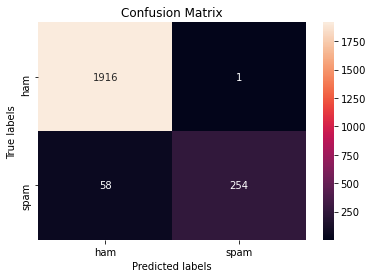

Blocked ham (false positive rate): 0.0005216484089723526%
Meets false positive threshold?  no
Spam caught (true positive rate): 0.8141025641025641%
F1 Beta Score:  0.9723586385649001


In [1684]:
spam_pipeline.fit(X_train, y_train)
preds = spam_pipeline.predict(X_test)
evaluate(preds)

The default SVM actually performed quite well on our dataset. Using the hold-out set, we are getting a false positive rate of 0.0005, which is in the ballpark of where we want to be. We are catching ~81% of spam, which is slightly better than the Naive Bayes default (79% of spam caught). Let's see how much we can improve the model by optimizing th model's hyperparameters.

In [1685]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state = RANDOM_STATE, test_size = TEST_RATIO)

              precision    recall  f1-score   support

         ham       0.97      1.00      0.99      1917
        spam       0.99      0.84      0.91       312

    accuracy                           0.98      2229
   macro avg       0.98      0.92      0.95      2229
weighted avg       0.98      0.98      0.98      2229



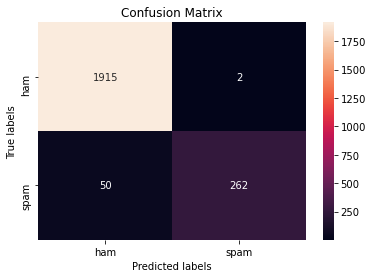

Blocked ham (false positive rate): 0.0010432968179447052%
Meets false positive threshold?  no
Spam caught (true positive rate): 0.8397435897435898%
F1 Beta Score:  0.9731156111441996
{'svc__C': 5, 'svc__kernel': 'rbf', 'vect__ngram_range': (1, 2)}


In [1686]:
spam_pipeline = Pipeline([('vect', CountVectorizer(lowercase=False, strip_accents='ascii', max_df=0.9, min_df=0.0005)),
                          ('tfidf', TfidfTransformer()),
                          ('svc', SVC(random_state=RANDOM_STATE)),])

# will try 56 different combinations
parameters = {
    'vect__ngram_range': [(1, 1), (1, 2)],
    'svc__C': [0.01, 0.1, 0.25, 0.5, 1, 2, 5], # regularization penalty
    'svc__kernel': ['linear', 'poly', 'rbf', 'sigmoid'],
}

gs_svm = GridSearchCV(spam_pipeline, parameters, scoring=fbeta_scorer, cv=CV_FOLDS, n_jobs=-1)

gs_svm.fit(X_train, y_train)
preds = gs_svm.predict(X_test)
evaluate(preds)

print(gs_svm.best_params_)

Here, we are getting two false positives in just the hold-out set, which is already more than what is acceptable. We are also only catching about 84% of spam messages, which is lower than our Multinomial Naive Bayes model. It is clear that we should reduce the beta parameter in the F1Beta score so that the model is penalized even more for making false positives. I also notice that both NB and SVM benefit from including bigrams. I may explore adding higher N-grams to the dataset.

## Embedding

Since our corpus is relatively small, we probably do not have enough text data to train our own embedding layers. Instead, we will turn to transfer learning, focusing on a particurily popular pretrained model, **GloVe**.

In [1687]:
# downloads model, unzips, and deletes original
if DOWNLOAD_GLOVE:
    !wget -P glove/ http://nlp.stanford.edu/data/glove.6B.zip
    !unzip glove/glove.6B.zip -d glove/
    !rm glove/glove.6B.zip

In [1688]:
from gensim.scripts.glove2word2vec import glove2word2vec
glove_input_file = 'glove/glove.6B.100d.txt'
word2vec_output_file = 'glove/word2vec.txt'
glove2word2vec(glove_input_file, word2vec_output_file)

/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/ipykernel/__main__.py:4: DeprecationWarning: Call to deprecated `glove2word2vec` (KeyedVectors.load_word2vec_format(.., binary=False, no_header=True) loads GLoVE text vectors.).


(400000, 100)

In [1689]:
from gensim.models import KeyedVectors
# load the Stanford GloVe model
emb = KeyedVectors.load_word2vec_format(word2vec_output_file, binary=False)

In [1690]:
emb['word']

array([ 0.1233  ,  0.55741 ,  0.74203 , -0.06547 , -0.33485 ,  0.81541 ,
       -0.16384 , -1.0327  ,  0.41834 , -0.012764, -0.60695 ,  0.30146 ,
        0.35976 ,  0.41161 ,  0.03381 , -0.091115,  0.35077 , -0.24798 ,
       -0.13128 ,  0.19869 ,  0.046961,  0.014633, -0.39851 , -0.11829 ,
       -0.27432 , -0.032518, -0.23637 , -0.072372, -0.04237 , -0.11159 ,
        0.12129 ,  0.64011 , -0.50275 , -0.21584 ,  0.30097 , -0.041772,
       -0.47972 , -0.12897 ,  0.6964  , -0.27594 , -0.29149 ,  0.088033,
        0.12874 , -0.15249 , -0.20548 ,  0.029435,  0.055133, -0.12994 ,
       -0.33869 , -0.61891 ,  0.4743  ,  0.60288 ,  1.0209  ,  0.48663 ,
       -1.0587  , -1.9711  , -0.41751 ,  0.12457 ,  1.304   ,  0.26925 ,
        0.28003 ,  0.91141 , -0.62217 , -0.70356 ,  1.0379  , -0.095316,
        0.54085 , -0.36123 , -0.10311 , -0.31059 , -0.61454 ,  0.63799 ,
        0.18329 , -0.49599 ,  0.3607  ,  0.70414 , -0.28096 ,  0.1062  ,
       -0.64866 , -0.28698 , -0.26623 , -1.4502  , 

Now that we can get high quality embeddings for each word in the GloVe vocabulary, we can take the average of those embeddings to get a sentence embedding that should approximate the relationship between sentences in the dataset.

In [1691]:
# takes a sentence in string format and returns average word embedding
def get_sentence_embedding(sentence, dimension):
    totalEmbedding = np.zeros(dimension)
    numValidWords = 0
    words = sentence.split(' ')
    for word in words:
        word = word.strip(' ')      # word may have whitespace, which could mess up embedding
        if emb.has_index_for(word): # for now, we will only accept words within the vocabulary
            totalEmbedding = totalEmbedding + emb[word] 
    if numValidWords == 0:
        return totalEmbedding       # no valid words were found in the sentence, return 0
    return totalEmbedding / numValidWords

In [1692]:
X_embed = X.apply(lambda x: get_sentence_embedding(x, 100))

In [1693]:
# converts Series with lists to DataFrame with multiple columns
X_embed = pd.DataFrame(X_embed.tolist())

In [1694]:
X_embed

,0,1,2,3,4,5,6,7,8,9,...,90,91,92,93,94,95,96,97,98,99
0,0.667930,1.085955,3.991036,-0.255475,-2.085316,1.008745,0.164294,3.865477,0.233446,-2.361942,...,-1.979312,-1.380415,1.853742,0.885214,-4.037860,-2.149489,-2.357920,-5.341131,6.486759,3.163435
1,0.373040,-0.778777,2.241010,-1.503951,-1.926815,1.864091,0.580568,0.752322,1.768932,-0.271360,...,-0.031955,0.168375,0.529797,-0.411748,0.759621,-0.366444,-0.358635,-1.217817,-2.417187,0.035798
2,0.301091,4.043170,6.388706,-1.685197,-0.727121,0.432027,1.322329,3.259246,-1.143771,-2.654820,...,-4.006984,2.444191,-0.505895,1.399688,-3.937110,-2.308505,5.400119,1.242996,4.757581,-0.754385
3,-1.425154,0.585155,0.980350,-0.120910,-2.047710,-1.547334,-0.993560,-0.548180,2.134575,-1.298941,...,2.161250,-1.918459,-1.403629,0.248540,-2.456080,0.607713,-1.333772,-3.294896,1.000334,-0.177560
4,-0.746491,3.247970,2.894838,-2.900791,-2.120800,2.004200,-0.450949,-0.918278,0.867740,-2.428010,...,0.716402,-1.434884,0.645988,-0.931120,-3.120871,-0.897635,-0.490556,-2.140934,1.781350,2.449977
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5567,-0.881483,3.097742,3.302300,0.445391,-0.453864,1.382492,2.289936,1.566903,-3.972439,0.369849,...,-2.728341,0.828132,-2.798959,-0.919668,-9.294059,-1.865856,2.235299,-1.901911,5.792311,-2.441222
5568,0.147762,1.355060,0.986150,-1.440420,-0.421987,1.158345,-0.623968,2.472060,-1.688314,-0.662538,...,-0.795013,-1.244846,-0.065419,0.158851,-2.635415,-0.726140,1.698310,-0.810910,2.036650,0.472350
5569,-1.330660,0.700470,2.292920,-1.194910,-1.648870,1.690237,-1.316311,-0.820660,0.645914,-0.909693,...,-0.827669,-1.014260,-0.872070,0.080161,-0.377790,0.864164,-0.417040,-1.228352,-0.305889,2.355530
5570,2.291357,2.488516,6.570093,-2.723735,-0.384974,1.480043,-1.333100,1.229575,-0.871575,-4.060801,...,0.206683,-2.514200,0.260202,-2.173616,-6.874606,-0.599175,-0.782111,-0.887472,5.921830,4.414111


Since some of our values are negative, we cannot use Naive Bayes. Some options are: SVM, NN, and Random Forest. We will try SVM first:

In [1695]:
X_train, X_test, y_train, y_test = train_test_split(X_embed, y, random_state = RANDOM_STATE, test_size = TEST_RATIO)

In [1696]:
svc = SVC(random_state = RANDOM_STATE)
svc.fit(X_train, y_train)

SVC(random_state=12)

              precision    recall  f1-score   support

         ham       0.97      0.99      0.98      1917
        spam       0.94      0.79      0.86       312

    accuracy                           0.96      2229
   macro avg       0.95      0.89      0.92      2229
weighted avg       0.96      0.96      0.96      2229



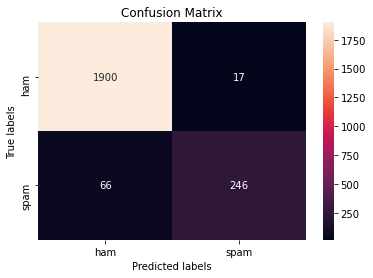

Blocked ham (false positive rate): 0.008868022952529996%
Meets false positive threshold?  no
Spam caught (true positive rate): 0.7884615384615384%
F1 Beta Score:  0.9167219972113405


In [1697]:
preds = svc.predict(X_test)
evaluate(preds)

On the holdout set, we are getting 17 false positives, far more than what is acceptable. We are also catching only 78.8% of spam. We could try optimizing the hyperparameters for this model but since the default hyperparameters performed so poorly, we will instead try a different algorithm. 

We will now see how the Random Forest algorithm performs on this dataset of embeddings:

In [1695]:
X_train, X_test, y_train, y_test = train_test_split(X_embed, y, random_state = RANDOM_STATE, test_size = TEST_RATIO)

In [1703]:
rf = RandomForestClassifier(random_state = RANDOM_STATE)
rf.fit(X_train, y_train)

RandomForestClassifier(random_state=12)

              precision    recall  f1-score   support

         ham       0.96      0.99      0.98      1917
        spam       0.93      0.78      0.85       312

    accuracy                           0.96      2229
   macro avg       0.95      0.88      0.91      2229
weighted avg       0.96      0.96      0.96      2229



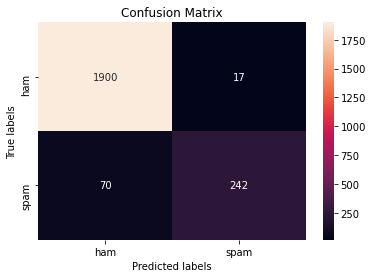

Blocked ham (false positive rate): 0.008868022952529996%
Meets false positive threshold?  no
Spam caught (true positive rate): 0.7756410256410257%
F1 Beta Score:  0.9139526276831977


In [1705]:
preds = rf.predict(X_test)
evaluate(preds)

With the default scikit learn Random Forest algorithm, we are getting almost the exact same results as the SVM algorithm with the embedding dataset. This suggests that the problem lies in the embeddings themselves, and not the algorithm. Here are a couple of ideas to improve the quality of the dataset:

It may improve the quality of the  embeddings to incorporate more sophisticated methods of sentence embeddings, such as weighted average, instead of normal average. We are also forced to discard many of the words in the posts, since they are not in the GloVe vocabulary. A more robust embedding solution may be required in order to retain some of the unique words that help differentiate spam messages from ham. 

## Modifying decision threshold

Creating a model that has such a low rate of false positives is going to be extremely difficult using the default decision threshold for binary classification (0.5). We may be able to achieve our low rate of false positive by raising the threshold. In this section, we will start by exploring the probabilities given to the false positive examples using our optimized Naive Bayes model and then explore the effect of changing the threshold on the false and true positive rates.

We first need to get back our optimized NB model. Note that we are still using RANDOM_STATE+1 in train_test_split because that holdout set resulted in false positives with our optimized NB model.

In [1706]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state = RANDOM_STATE+1, test_size = TEST_RATIO)

In [1707]:
# recreate pipeline with optimal hyperparameters
spam_pipeline = Pipeline([('vect', CountVectorizer(lowercase=False, strip_accents='ascii', max_df=0.9, min_df=0.0005)),
                          ('tfidf', TfidfTransformer()),
                          ('nb', MultinomialNB()),])

spam_pipeline.set_params(**gs_nb.best_params_)
spam_pipeline.fit(X_train, y_train)

Pipeline(steps=[('vect',
                 CountVectorizer(lowercase=False, max_df=0.9, min_df=0.0005,
                                 ngram_range=(1, 2), strip_accents='ascii')),
                ('tfidf', TfidfTransformer()),
                ('nb', MultinomialNB(alpha=0.25))])

In [1730]:
X_test_arr = np.asarray(X_test)
y_test_arr = np.asarray(y_test)

false_positives = []
pos_conf = []

for i in range(len(X_test_arr)):
    item = np.asarray([X_test_arr[i]])
    pred = spam_pipeline.predict(item)[0]
    actual = y_test_arr[i]
    
    # only look at incorrect predictions
    if not pred == actual:
        # false positives
        if pred == 1 and actual == 0:
            false_positives.append(X_test_arr[i])
            conf = spam_pipeline.predict_proba(item)[0][1] # get confidence in positive prediction
            pos_conf.append(conf)

In [1732]:
print('Number of false positives: ', len(false_positives))
print('False positives: ')
for i in range(len(false_positives)):
    print(f'{i}.')
    print('\tMessage: ', false_positives[i])
    print('\tConfidence: ', pos_conf[i])

Number of false positives:  3
False positives: 
0.
	Message:  received understood acted upon
	Confidence:  0.596949574017098
1.
	Message:  nokia phone lovly
	Confidence:  0.7983643405913631
2.
	Message:  deleted contact
	Confidence:  0.5754456085425226


From these results, we can see that the model is not very confident about two of the three false positives (~.57-.59 probability). It is somewhat confident about the other message (.798 probability of being spam) but the message is both cryptic and uses words that are often in spam messages. We could increase the threshold to 0.8 to eliminate all false positives from this hold out set but we would most likely reduce the number of true positives. Increasing the threshold to 0.6 would eliminate two of the three false positives and most likely retain most of the existing true positives. This might be acceptable if the remaining false positive is the only one remaining in the entire dataset (would need to check using cross validation). We will now explore the effect of different thresholds on the false and true positive rates:

In [1756]:
# recreate pipeline with optimal hyperparameters
spam_pipeline = Pipeline([('vect', CountVectorizer(lowercase=False, strip_accents='ascii', max_df=0.9, min_df=0.0005)),
                          ('tfidf', TfidfTransformer()),
                          ('nb', MultinomialNB()),])

spam_pipeline.set_params(**gs_nb.best_params_)

Pipeline(steps=[('vect',
                 CountVectorizer(lowercase=False, max_df=0.9, min_df=0.0005,
                                 ngram_range=(1, 2), strip_accents='ascii')),
                ('tfidf', TfidfTransformer()),
                ('nb', MultinomialNB(alpha=0.25))])

In [1770]:
# returns total true positives and false positives (for all folds) given a specific decision threshold
# returnType can either be 'rate', which returns the true positive rate and the false positive rate, or 'num', which returns the total number of true positives versus the total number of false positives
def nb_threshold_test(threshold, returnType = 'rate'):

    # building custom cross validation so we can use predict_proba()
    # we use Stratified K-fold so that we preserve the class imbalance that is present in the larger dataset
    skf = StratifiedKFold(n_splits=CV_FOLDS)
    
    # variables to keep track of total TP & FP's (for 'num' returnType)
    totalFP = 0
    totalTP = 0
    
    # variables to keep track of sum of TP & FP rates (for 'rate' returnType)
    TPRateSum = 0
    FPRateSum = 0
    
    for train_index, test_index in skf.split(X, y):
        # get subset dataframes
        X_train_strat, X_test_strat = X[train_index], X[test_index]
        y_train_strat, y_test_strat = y[train_index], y[test_index]

        # fit on train set
        spam_pipeline.fit(X_train_strat, y_train_strat)

        # get predictions on test set based on probability
        y_pred = (spam_pipeline.predict_proba(X_test_strat)[:,1] >= threshold).astype(float)
        
        # make sure we have the same number of predictions as labels
        y_test_strat = np.asarray(y_test_strat)
        if not len(y_pred) == len(y_test_strat):
            raise
        
        # calculate false positives and true positives
        numFP = 0
        numTP = 0
        for i in range(len(y_pred)):
            if y_pred[i] == 1 and y_test_strat[i] == 1:
                numTP += 1
            elif y_pred[i] == 1 and y_test_strat[i] == 0:
                numFP += 1

        # update total TP & FP numbers
        totalFP += numFP
        totalTP += numTP
        
        # calculate TP rate and FP rate and update totals
        TPRateSum += get_tpr(y_test_strat, y_pred)
        FPRateSum += get_fpr(y_test_strat, y_pred)    
    
    if returnType == 'num':
        return totalTP, totalFP
    else:
        # get average between folds
        avgTPRate = TPRateSum / CV_FOLDS
        avgFPRate = FPRateSum / CV_FOLDS
        return avgTPRate, avgFPRate

In [1771]:
nb_threshold_test(0.5)

(0.8941834451901567, 0.0010362694300518134)

In [1772]:
nb_threshold_test(0.9)

(0.7831140939597315, 0.0)

Now that we have a function that can take a threshold and return true and false positive rates (or the total numbers of each), let's plot the results with various threshold values. We'll plot the true and false positive rates for values between 0.4 and 1 with a 0.025 step size.

In [1801]:
x = []
true_pos_y = []
false_pos_y = []

for t in np.arange(0.4, 1, 0.025):
    results = nb_threshold_test(t)
    tpr = results[0]
    fpr = results[1]
    print('Threshold: {}, True Positive Rate: {}, False Positive Rate: {}'.format(t, tpr, fpr))
    x.append(t)
    true_pos_y.append(tpr)
    false_pos_y.append(fpr)

Threshold: 0.4, True Positive Rate: 0.908903803131991, False Positive Rate: 0.0022797927461139893
Threshold: 0.42500000000000004, True Positive Rate: 0.906228187919463, False Positive Rate: 0.002072538860103627
Threshold: 0.45000000000000007, True Positive Rate: 0.9022102908277405, False Positive Rate: 0.001243523316062176
Threshold: 0.4750000000000001, True Positive Rate: 0.8968501118568233, False Positive Rate: 0.0010362694300518134
Threshold: 0.5000000000000001, True Positive Rate: 0.8941834451901567, False Positive Rate: 0.0010362694300518134
Threshold: 0.5250000000000001, True Positive Rate: 0.8914988814317674, False Positive Rate: 0.0010362694300518134
Threshold: 0.5500000000000002, True Positive Rate: 0.8848053691275167, False Positive Rate: 0.0010362694300518134
Threshold: 0.5750000000000002, True Positive Rate: 0.8821297539149888, False Positive Rate: 0.0010362694300518134
Threshold: 0.6000000000000002, True Positive Rate: 0.8741118568232661, False Positive Rate: 0.00062176165

We will have to plot them on different axes because the scales are so different.

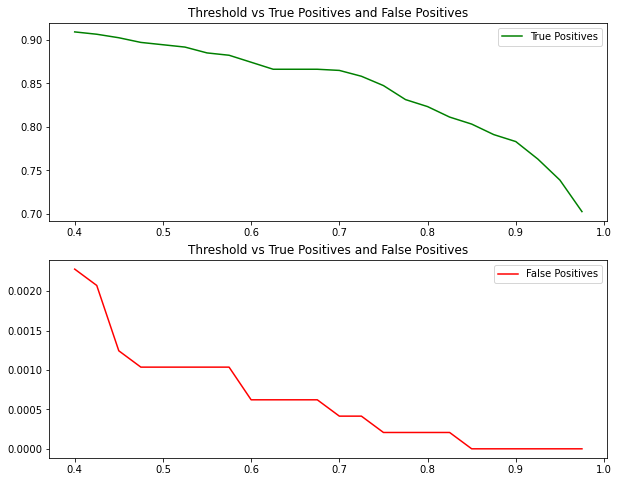

In [1802]:
plt.rcParams['figure.figsize'] = [10, 8]

plt.subplot(2, 1, 1)
plt.title('Threshold vs True Positives and False Positives')
plt.plot(x, true_pos_y, label = "True Positives", color='green')
plt.legend()

plt.subplot(2, 1, 2)
plt.title('Threshold vs True Positives and False Positives')
plt.plot(x, false_pos_y, label = "False Positives", color='red')
plt.legend()

plt.show()

These results demonstrate the tradeoff between true positives and false positives. We are able to satisfy our strict requirement around false positives by increasing our decision threshold. With a decision threshold of 0.85, we are able to eliminate all false positives in our dataset and we are able to catch ~80.3% of spam messages. The literature's best baseline model with a 0% false positive rate (indicated by 'BH' for blocked ham in the paper) is only able to detect ~54% of spam. Our model provides a ~26% improvement at catching spam over this baseline model while still keeping the blocked ham to zero. 

If we were to relax our requirement slightly on the false positive rate to 0.00021 (which equates to about 1 in every 4,762 ham messages being blocked), we would be able to increase the amount of spam we catch to ~84.7%. This solution would still block much less ham than the best baseline model in the literature (0.021% as opposed to 0.18%) and catches more spam (84.7% as opposed to 83.1%). 

However, I believe that a real spam detection solution *does* need to meet the strict false positive requirement outlined at the beginning of this notebook. Therefore, our best option so far is our optimized Naive Bayes classifier with a decision threshold of 0.85, which results in **no blocked ham** and **catches ~80.3% of spam**.